In [1]:
# pip install quandl

#### 1. Introduction
#### 1.a. Quantitative Momentum Strategy
#### 1.b. DataScope Select API
#### 2. Importing required packages
#### 3. Extracting list of all FTSE stock's
#### 4. Pulling Intraday data of all the stocks in the FTSE using DataScope Select API
#### 5. Calculating Percentage Change and Momentum of all Stocks
#### 6. Finding stocks with greater momentum
#### 7. Backtesting the strategy
#### 8. Conclusion

### Introduction

With tens of thousands of stocks to choose from, how do we go about selecting a few worth buying? Stock news, uncertainty and emotions add to the bitterness of this process. Whatever some experts suggest, it is impossible to go through all balance sheets to identify companies with low net debt and improving net profit margins.

This article uses a simple quantitative momentum strategy using Python and Refinitiv's DataScope Select (DSS) API. It filters and selects the best Intraday stocks.


In Physics, the term Momentum is used to define an object’s quantity and direction of motion. Similarly in financial markets, the momentum of an asset is the direction and speed of price change of the asset in the market.

#### What is Quantitative Momentum Strategy?
Quantitative Momentum is an investment strategy which selects stocks for investment whose price increased the most during a period. It is the process of identifying stocks with a great uptrend.

Momentum is considered a primary stock factor (a.k.a anomaly, or smart-beta factor) affecting stock returns. Academic research and practitioners’ experience show that Momentum has been outperforming the stock indices all over the world

#### DataScope Select API (DSS API)
The DataScope Select APIs offer programmatic access to Refinitiv content in a more flexible way than the browser- and FTP-based data access solutions. They can be used to create an infinite number of client applications written in any desired programming language, for example, C#, C++, Visual Basic, Java, Objective-C and Swift.

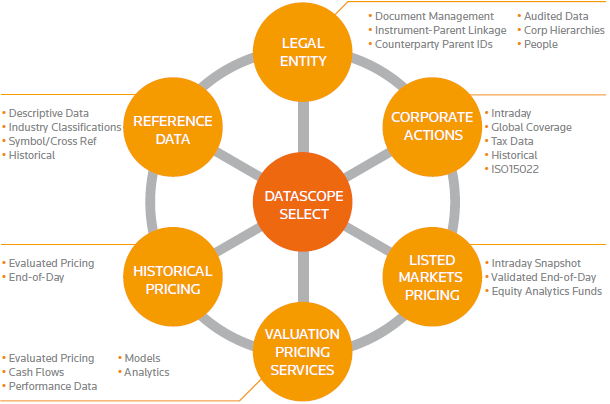

DSS REST API supports the management of instrument and entity lists, report templates and schedules for the purpose of requesting extractions. It also supports higher level calls that can make data extractions directly, without requiring the creation of instrument lists, report templates or schedules on the DSS server.

For more information, please read [here](https://developers.refinitiv.com/en/api-catalog/datascope-select/datascope-select-rest-api).



### Importing required packages

Let's see how this strategy can be implemented in Python using DSS API.

In [2]:
import os
import gzip
import pandas as pd
import requests
import numpy as np
from scipy.stats import percentileofscore as score
from math import floor
from json import dumps, loads
from requests import get, post
from time import sleep 
from getpass import getpass, GetPassWarning
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc_file_defaults()

Here, `Pandas` package is used to deal with data, the `NumPy` package is used to work with arrays, the `Requests` package is used to pull data using DSS API, the `Math` package is used for mathematical functions, the `SciPy` package is used for complex functions, and the `Statistics` package is used for statistical functions, and few other packages are also used for support.

After importing all the required packages into our python environment, let's define a function to authenticate connection with DSS API

In [3]:
def RequestNewToken(username="",password=""):
    '''
    username: DSS API login id
    password: DSS API login password
    '''
    _AuthenURL = "https://selectapi.datascope.refinitiv.com/RestApi/v1/Authentication/RequestToken"
    _header= {}
    _header['Prefer']='respond-async'
    _header['Content-Type']='application/json; odata.metadata=minimal'
    _data={'Credentials':{
        'Password':password,
        'Username':username
        }
    }

    print("Send Login request")
    resp=post(_AuthenURL,json=_data,headers=_header)

    if resp.status_code!=200:
        message="Authentication Error Status Code: "+ str(resp.status_code) +" Message:"+dumps(loads(resp.text),indent=4)
        raise Exception(str(message))

    return loads(resp.text)['value']

In [4]:
# Taking DSS username and password input from user
_DSSUsername = input('Username: ')
_DSSPassword = getpass('Password: ')
try:
    _token = RequestNewToken(_DSSUsername,_DSSPassword)
    print("Token="+_token+"\n")
except GetPassWarning as e:
    print(e)

Username: 9030588
Password: ········
Send Login request
Token=_H2Ue4WChJVGf31efJPd9jUpNN9r6-x72Iy9gFfCSJAMBCFGcrVhkjESeUMCNeiNmusp6m29KQKS3Fge52Pmt_3bSCVEv2Uxy0DlcPz09A1sJ3biBPF-6qeUNpfp6yudwVjZwSXaL3fn28TIqCnFNJMEnx7ST1o4HymWMze7Qu-z6UfNyZJas39nglkdIHiDrUW4HX67m5H0Wmj4gEzuhhZlXl3GrX_w08QGVxVe7aOkoJaMtlRV1irD5ShQgPTXgiPWkvfrQ_oJsx4KoNIJfijlfB_brGME8lv8hKV5DeJQ



This authentication token will be valid for 24hrs from the time of generation.

### Extracting List of all FTSE 100 Stock’s 

Next we are going to extract the list of all FTSE 100 stock’s using `0#.FTSE` ChainRic from DSS API.

For this let's define a function to expand this ChainRic.

In [5]:
def ExpandChain(token,json_payload):
    '''
    token: Authentication token generated from the above step
    json_payload: Sample json object which application parses to get the RIC list by accessing the value of Constituents.
    '''
    _expandChainURL = "https://selectapi.datascope.refinitiv.com/RestApi/v1/Search/HistoricalChainResolution"
    _header = {}
    _header['Prefer'] = 'respond-async'
    _header['Content-Type'] = 'application/json; odata.metadata=minimal'
    _header['Accept-Charset'] = 'UTF-8'
    _header['Authorization'] = 'Token' + token
    resp = post(_expandChainURL, data=None, json=json_payload, headers=_header)
    
    dataFrame= pd.DataFrame()
    if(resp.status_code==200):
        json_object=loads(resp.text,object_pairs_hook=OrderedDict)
        if len(json_object['value']) > 0:
            dataFrame = pd.DataFrame.from_dict(json_object['value'][0]['Constituents'])
    else:
        print("Unable to expand chain response return status code:",resp.status_code)
        
    return dataFrame

In this code,we have used DSS API to extract the RICs and it's status of the stocks available in the <b>FTSE 100</b> by sending request to DSS's RestAPI using `request` package. This function will post the request to `HistoricalChainResolution` and will return the data in dataframe format.

In [6]:
# Defining ChainRic, start date and end date
_chainRIC = "0#.FTSE"
_startDate = "2022-01-13"
_endDate = "2022-01-13"

In [7]:
try:
    if(_token!=""):
        # Sample JSON body 
        _jsonquery={
                    "Request": {
                        "ChainRics": [
                                _chainRIC
                                ],
                        "Range": {
                            "Start": _startDate,
                            "End": _endDate
                        }
                     }
        }
        df=ExpandChain(_token,_jsonquery)
        if df.empty:
            print("Unable to expand chain "+_chainRIC) 
        else:
            ricCount=len(df['Identifier'])
            print("Total "+str(ricCount)+" RICs available in "+ _chainRIC)
            # Filter and print only RIC name and Status columns
            pd.set_option('display.max_rows', ricCount)
            ftse_ric = df.filter(items=['Identifier','Status'])
            ftse_ric.index = np.arange(1,len(ftse_ric)+1)
            print(ftse_ric)
            pd.reset_option('display.max_rows')
            
except Exception as ex:
    print("Exception occrus:", ex)

Total 103 RICs available in 0#.FTSE
    Identifier Status
1        .FTSE  Valid
2     .AD.FTSE  Valid
3        AAL.L  Valid
4       ABDN.L  Valid
5        ABF.L  Valid
6       ADML.L  Valid
7        AHT.L  Valid
8       ANTO.L  Valid
9      AUTOA.L  Valid
10        AV.L  Valid
11      AVST.L  Valid
12       AVV.L  Valid
13       AZN.L  Valid
14      BAES.L  Valid
15      BARC.L  Valid
16      BATS.L  Valid
17      BDEV.L  Valid
18      BHPB.L  Valid
19      BKGH.L  Valid
20      BLND.L  Valid
21      BMEB.L  Valid
22      BNZL.L  Valid
23        BP.L  Valid
24      BRBY.L  Valid
25        BT.L  Valid
26       CCH.L  Valid
27       CPG.L  Valid
28      CRDA.L  Valid
29       CRH.L  Valid
30       DCC.L  Valid
31       DGE.L  Valid
32       DPH.L  Valid
33       ECM.L  Valid
34       ENT.L  Valid
35      EVRE.L  Valid
36      EXPN.L  Valid
37      FERG.L  Valid
38     FLTRF.L  Valid
39      FRES.L  Valid
40      GLEN.L  Valid
41       GSK.L  Valid
42       HIK.L  Valid
43      HLMA.L  Va

In [8]:
# List of RICs available in FTSE100
ftse_list = ftse_ric.Identifier.values
print(ftse_list)

['.FTSE' '.AD.FTSE' 'AAL.L' 'ABDN.L' 'ABF.L' 'ADML.L' 'AHT.L' 'ANTO.L'
 'AUTOA.L' 'AV.L' 'AVST.L' 'AVV.L' 'AZN.L' 'BAES.L' 'BARC.L' 'BATS.L'
 'BDEV.L' 'BHPB.L' 'BKGH.L' 'BLND.L' 'BMEB.L' 'BNZL.L' 'BP.L' 'BRBY.L'
 'BT.L' 'CCH.L' 'CPG.L' 'CRDA.L' 'CRH.L' 'DCC.L' 'DGE.L' 'DPH.L' 'ECM.L'
 'ENT.L' 'EVRE.L' 'EXPN.L' 'FERG.L' 'FLTRF.L' 'FRES.L' 'GLEN.L' 'GSK.L'
 'HIK.L' 'HLMA.L' 'HRGV.L' 'HSBA.L' 'ICAG.L' 'ICP.L' 'IHG.L' 'III.L'
 'IMB.L' 'INF.L' 'ITRK.L' 'ITV.L' 'JD.L' 'KGF.L' 'LAND.L' 'LGEN.L'
 'LLOY.L' 'LSEG.L' 'MGGT.L' 'MNDI.L' 'MNG.L' 'MRON.L' 'NG.L' 'NWG.L'
 'NXT.L' 'OCDO.L' 'PHNX.L' 'POLYP.L' 'PRU.L' 'PSHP.L' 'PSN.L' 'PSON.L'
 'RDSa.L' 'RDSb.L' 'REL.L' 'RIO.L' 'RKT.L' 'RMG.L' 'RMV.L' 'RR.L' 'RTO.L'
 'SBRY.L' 'SDR.L' 'SGE.L' 'SGRO.L' 'SJP.L' 'SKG.L' 'SMDS.L' 'SMIN.L'
 'SMT.L' 'SN.L' 'SPX.L' 'SSE.L' 'STAN.L' 'SVT.L' 'TSCO.L' 'TW.L' 'ULVR.L'
 'UU.L' 'VOD.L' 'WPP.L' 'WTB.L']


We first extracted the RICs and Status of the stocks in the FTSE 100 using the `ExpandChain` function and stored it into the <i>ftse_ric</i> dataframe. Then we defined a variable ‘ftse_list’ to store the extracted data into a NumPy array. 

To learn more about "How to expand Chain RIC using the Tick History REST API in Python", visit [here](https://developers.refinitiv.com/en/article-catalog/article/how-expand-chain-ric-using-tick-history-rest-api-python).

### Pulling Intraday data of all the stocks in the FTSE using DataScope Select API

We have seen list of all the FTSE 100 stock’s RICs, now let’s pull some intraday data using DSS API.

For this let's define a function to extract data first for the given ChainRic, i.e., `#0.FTSE`.

In [9]:
def ExtractRaw(token,json_payload):
    try:
        _extractRawURL="https://selectapi.datascope.refinitiv.com/RestApi/v1/Extractions/ExtractRaw"
        # Setup Request Header
        _header={}
        _header['Prefer']='respond-async'
        _header['Content-Type']='application/json; odata.metadata=minimal'
        _header['Accept-Charset']='UTF-8'
        _header['Authorization']='Token'+token

        # Post Http Request to DSS server using extract raw URL
        resp=post(_extractRawURL,data=None,json=json_payload,headers=_header)

        # Print Status Code return from HTTP Response
        print("Status Code="+str(resp.status_code) )

        # Raise exception with error message if the returned status is not 202 (Accepted) or 200 (Ok)
        if resp.status_code!=200:
            if resp.status_code!=202:
                message="Error: Status Code:"+str(resp.status_code)+" Message:"+resp.text
                raise Exception(message)

            # Get location from header, URL must be https so we need to change it using string replace function
            _location=str.replace(resp.headers['Location'],"http://","https://")

            print("Get Status from "+str(_location))
            _jobID=""

            # Pooling loop to check request status every 30 sec.
            while True:
                resp=get(_location,headers=_header)
                _pollstatus = int(resp.status_code)

                if _pollstatus==200:
                    break
                else:
                    print("Status:"+str(resp.headers['Status']))
                sleep(retryInterval) # wait for _retyInterval period and re-request the status to check if it already completed

        # Get the jobID from HTTP response
        json_resp = loads(resp.text)
        _jobID = json_resp.get('JobId')
        print("Status is completed the JobID is "+ str(_jobID)+ "\n")

        # Check if the response contains Notes.If the note exists print it to console.
        if len(json_resp.get('Notes')) > 0:
            print("Notes:\n======================================")
            for var in json_resp.get('Notes'):
                print(var)
            print("======================================\n")

        # Request should be completed then Get the result by passing jobID to RAWExtractionResults URL
        _getResultURL = str("https://selectapi.datascope.refinitiv.com/RestApi/v1/Extractions/RawExtractionResults(\'" + _jobID + "\')/$value")
        print("Retrieve result from " + _getResultURL)
        resp=get(_getResultURL,headers=_header,stream=True)

        # Write Output to file
        outputfilepath = str("FTSE_100_" + str(os.getpid()) + '.csv.gz')
        if resp.status_code==200:
            with open(outputfilepath, 'wb') as f:
                f.write(resp.raw.read())

        # Read data from csv.gz and shows output from dataframe head() and tail() 
        df=pd.read_csv(outputfilepath,compression='gzip')
        return df

    except Exception as ex:
        print("Exception occrus:", ex)

In this function as well, we have used DSS API to extract the data for all the RICs of <b>FTSE 100</b> by sending request to DSS's RestAPI using request package. We first setup the request header and post the request to `ExtractRaw` to fetch data.

The fetched data will be written to a csv file using `gzip` compression, will be loaded to a dataframe and returned.

In case, if there will be any exception that will be raised, for example if the request's returned status is not `Accepted` or `Ok`.

In [10]:
# value in second used by Pooling loop to check request status on the server
retryInterval=int(30) 

# Sample JSON for FTSE ChainRic for pulling data within the given date range
ftse_json = {
    "ExtractionRequest": {
        "@odata.type": "#DataScope.Select.Api.Extractions.ExtractionRequests.TickHistoryIntradaySummariesExtractionRequest",
        "ContentFieldNames": [
            "High",
            "Last",
            "Low",
            "Open",
            "Volume"
        ],
       "IdentifierList": {
            "@odata.type": "#DataScope.Select.Api.Extractions.ExtractionRequests.InstrumentIdentifierList",
            "InstrumentIdentifiers": [{
                "Identifier": "0#.FTSE",
                "IdentifierType": "ChainRIC"
            }
            ],
            "UseUserPreferencesForValidationOptions" : "False"
        },
        "Condition": {
            "MessageTimeStampIn": "LocalExchangeTime",
            "ReportDateRangeType": "Range",
            "QueryStartDate": "2022-01-13T00:00:00.000000000Z",
            "QueryEndDate": "2022-01-13T23:59:59.999999999Z",
            "SummaryInterval": "OneMinute",
            "DisplaySourceRIC": "True"
        }
    }
}

Here, we have defined `retryInterval` variable for re-requesting the status after it's value (in second) to check if post request is already completed.

In [11]:
# Read the HTTP request body for the FTSE JSON defined above.
ftse_df = ExtractRaw(_token,ftse_json)

Status Code=202
Get Status from https://selectapi.datascope.refinitiv.com/RestApi/v1/Extractions/ExtractRawResult(ExtractionId='0x07dd8e08527d7c8f')
Status:InProgress
Status:InProgress
Status:InProgress
Status is completed the JobID is 0x07dd8e08527d7c8f

Notes:
Extraction Services Version 15.2.42998 (497fbb60729e), Built Nov 11 2021 19:36:12
User ID: 9030588
Extraction ID: 2000000353107235
Correlation ID: CiD/9030588/0x0000000000000000/REST API/EXT.2000000353107235
Schedule: 0x07dd8e08527d7c8f (ID = 0x0000000000000000)
Input List (1 items):  (ID = 0x07dd8e08527d7c8f) Created: 2022/01/17 02:11:49 Last Modified: 2022/01/17 02:11:49
Report Template (5 fields): _OnD_0x07dd8e08527d7c8f (ID = 0x07dd8e08528d7c8f) Created: 2022/01/17 02:08:04 Last Modified: 2022/01/17 02:08:04
Schedule dispatched via message queue (0x07dd8e08527d7c8f), Data source identifier (EC905BA932A744FC8E2F0C9C3BADE040)
Schedule Time: 2022/01/17 02:08:04
Processing started at 2022/01/17 02:08:04
Processing completed suc

Here, we can see the Status and progress of the `ExtractRaw` function. Once the data is fetched completely, few metadata for each of the RICs is displayed such as #RIC, Domain, Start, End, Status, and Count. We can also view all the data values fetched using the last url printed at the end.

In [12]:
ftse_df.head()

,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Open,High,Low,Last,Volume
0,.FTSE,NaN,Market Price,2022-01-13T08:00:00.000000000Z,Intraday 1Min,7551.70,7553.41,7534.32,7537.40,11701819
1,.FTSE,NaN,Market Price,2022-01-13T08:01:00.000000000Z,Intraday 1Min,7537.45,7541.93,7537.45,7540.01,4144926
2,.FTSE,NaN,Market Price,2022-01-13T08:02:00.000000000Z,Intraday 1Min,7539.95,7540.36,7536.60,7537.22,3154307
3,.FTSE,NaN,Market Price,2022-01-13T08:03:00.000000000Z,Intraday 1Min,7537.18,7538.59,7536.81,7537.36,4674796
4,.FTSE,NaN,Market Price,2022-01-13T08:04:00.000000000Z,Intraday 1Min,7537.06,7540.01,7536.89,7539.78,3403918


If you don’t know how to pull stock data using DSS API, I suggest to read article on it [here](https://developers.refinitiv.com/en/article-catalog/article/request-tick-history-time-and-sales-data-using-python).

#### Data Pre-Processing 
At this step, we will pre-process the data to get it ready in the desired format.

In [13]:
ftse_df['Date-Time'] = ftse_df['Date-Time'].apply(lambda x: x.split('.')[0][:-3])
ftse_df = ftse_df[['#RIC', 'Date-Time', 'Last']]
ftse_df.columns = ['RIC', 'Time', 'Close']
ftse_df.head()

,RIC,Time,Close
0,.FTSE,2022-01-13T08:00,7537.40
1,.FTSE,2022-01-13T08:01,7540.01
2,.FTSE,2022-01-13T08:02,7537.22
3,.FTSE,2022-01-13T08:03,7537.36
4,.FTSE,2022-01-13T08:04,7539.78


In [14]:
ftse_df_list = []
for ric in ftse_list:
    temp_df = ftse_df[ftse_df['RIC']==ric][['Time', 'Close']]
    temp_df.columns = ['Time', ric]
    temp_df = temp_df.set_index('Time')
    ftse_df_list.append(temp_df)
    
final_ftse_df = pd.concat(ftse_df_list, axis=1)
final_ftse_df.sort_index(inplace=True)
final_ftse_df.dropna(how='all', axis=1, inplace=True)
final_ftse_df.head()

,.FTSE,AAL.L,ABDN.L,ABF.L,ADML.L,AHT.L,ANTO.L,AUTOA.L,AV.L,AVST.L,...,SSE.L,STAN.L,SVT.L,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WPP.L,WTB.L
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-13T07:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.4713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-13T08:00,7537.40,3360.0,245.000,2087.121,3093.0,5838.00,1437.5,705.6,431.850,604.0000,...,1585.8160,499.0000,2834.0,284.3500,159.75000,3882.0,1047.000,116.5000,1179.0000,3117.0000
2022-01-13T08:01,7540.01,3360.5,244.900,NaN,NaN,5846.76,1431.5,705.2,432.300,604.2513,...,1585.4265,500.6000,2829.6,284.8000,160.30000,3884.0,NaN,116.6200,1181.3500,3124.2022
2022-01-13T08:02,7537.22,3353.5,NaN,2090.049,3092.0,5836.00,1433.0,NaN,430.600,NaN,...,1584.9265,499.9490,NaN,285.4793,160.65000,3884.9,1046.713,116.7400,NaN,3128.0000
2022-01-13T08:03,7537.36,3355.0,245.201,2089.210,NaN,5842.00,1436.0,708.0,430.751,NaN,...,1581.5000,499.4000,NaN,285.8988,160.78529,3881.5,1049.000,116.6798,1181.1585,3123.9820


Since, now the data is ready in the desired format, now we will save the extracted intraday data of all FTSE 100 stocks. We also dropped column with all null values. It is an optional step but a good practice to save time, so first saving the extracted intraday data in the name of ‘ftse100’ using the ‘to_csv’ function provided by the Pandas package. 

In [15]:
final_ftse_df.shape

(541, 102)

In [16]:
final_ftse_df.to_csv('ftse100.csv')

### Calculating Percentage Change and Momentum of all Stocks¶

In [17]:
# CALCULATING DAY CHANGE OF STOCKS

dc = []
for i in final_ftse_df.columns:
    dc.append(final_ftse_df[i].pct_change().sum())
    
ftse100_momentum = pd.DataFrame(columns = ['symbol', 'day_change'])
ftse100_momentum['symbol'] = final_ftse_df.columns
ftse100_momentum['day_change'] = dc

# CALCULATING MOMENTUM

ftse100_momentum['momentum'] = 'N/A'
for i in range(len(ftse100_momentum)):
    ftse100_momentum.loc[i, 'momentum'] = score(ftse100_momentum.day_change, ftse100_momentum.loc[i, 'day_change'])/100
    
ftse100_momentum['momentum'] = ftse100_momentum['momentum'].astype(float)    
print(ftse100_momentum.head())

   symbol  day_change  momentum
0   .FTSE    0.003509  0.558824
1   AAL.L   -0.001400  0.372549
2  ABDN.L    0.002903  0.549020
3   ABF.L    0.010944  0.833333
4  ADML.L    0.006481  0.696078


First, we created an empty list named `dc` to store the percentage change of each stock. Using for loop, we are iterating over the RICs of all the stocks in the FTSE 100 and appended the calculated percentage change using the ‘pct_change’ function provided by the Pandas package into the ‘dc’ list. Then we created a dataframe named `ftse100_momentum` to store the symbol of the stock, percentage change, and the momentum which we calculated after this.

To calculate the momentum, we first created a column named ‘momentum’ in the ‘ftse100_momentum’ dataframe and filled it with null values. Then we passed on a for-loop to fill the null values with the actual momentum values.

### Finding Stocks with Greater Momentum

First, we will create a dataframe named ‘top_picks’ which stores the top 10 stocks having greater momentum than the rest. <br>
In order to sort and find the top 10 stocks, we used the ‘nlargest’ function provided by the Pandas package.

In [18]:
top_picks = ftse100_momentum.nlargest(10, 'momentum')['symbol'].reset_index().drop('index', axis = 1)
print(top_picks)

   symbol
0  ICAG.L
1    BT.L
2   PRU.L
3  HSBA.L
4  STAN.L
5   NWG.L
6   PSN.L
7   IMB.L
8   MNG.L
9  LLOY.L


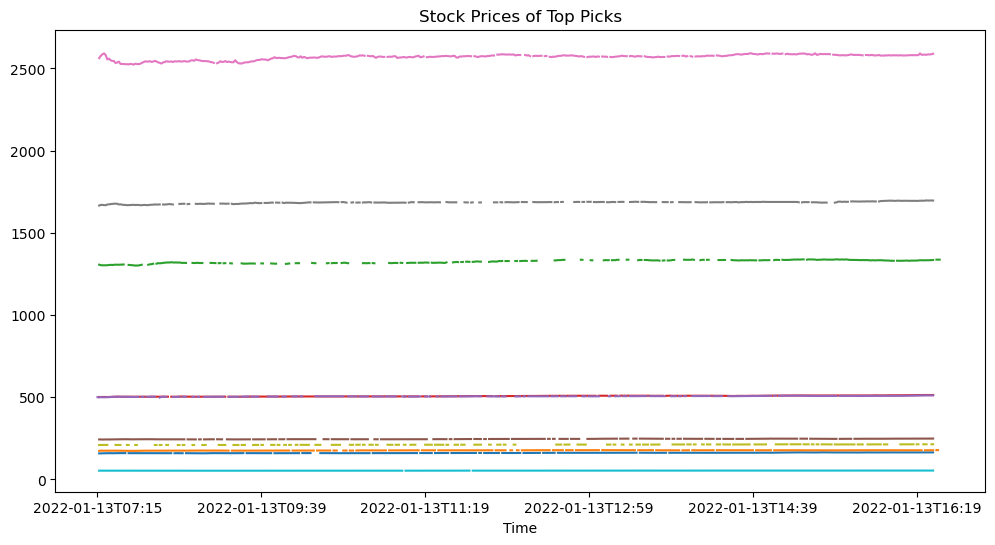

In [27]:
for ticks in top_picks['symbol']:
    final_ftse_df[ticks].plot(label = ticks, figsize = (12,6))
plt.title('Stock Prices of Top Picks')
plt.show()

### Backtesting the strategy

In this step, we are going to backtest Quantitative Momentum Strategy by investing money in the top 10 stocks with the highest momentum, and let’s see what results we get.

First, we will define two variables:
1. One to store the total investment value
2. And other to store the investment value per stock 

Next, we will use a `for` loop to find the day’s close price of all the top 10 stocks and append those values into the ‘day_close’ variable. 

In further lines of code, we will create a dataframe named ‘backtest_df’ which will be comprised of the calculated number of stocks to buy in each of them, the returns we got by investing in those top 10 stocks, and finally the return percentage of our investment.

In [19]:
final_ftse_df.head()

,.FTSE,AAL.L,ABDN.L,ABF.L,ADML.L,AHT.L,ANTO.L,AUTOA.L,AV.L,AVST.L,...,SSE.L,STAN.L,SVT.L,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WPP.L,WTB.L
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-13T07:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.4713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-13T08:00,7537.40,3360.0,245.000,2087.121,3093.0,5838.00,1437.5,705.6,431.850,604.0000,...,1585.8160,499.0000,2834.0,284.3500,159.75000,3882.0,1047.000,116.5000,1179.0000,3117.0000
2022-01-13T08:01,7540.01,3360.5,244.900,NaN,NaN,5846.76,1431.5,705.2,432.300,604.2513,...,1585.4265,500.6000,2829.6,284.8000,160.30000,3884.0,NaN,116.6200,1181.3500,3124.2022
2022-01-13T08:02,7537.22,3353.5,NaN,2090.049,3092.0,5836.00,1433.0,NaN,430.600,NaN,...,1584.9265,499.9490,NaN,285.4793,160.65000,3884.9,1046.713,116.7400,NaN,3128.0000
2022-01-13T08:03,7537.36,3355.0,245.201,2089.210,NaN,5842.00,1436.0,708.0,430.751,NaN,...,1581.5000,499.4000,NaN,285.8988,160.78529,3881.5,1049.000,116.6798,1181.1585,3123.9820


In [22]:
# BACKTEST
final_ftse_df_copy = final_ftse_df.copy()
final_ftse_df_copy.fillna(-1, inplace=True)
portfolio_val = 1000000
per_stock_val = portfolio_val/len(top_picks)
day_close = []
for i in top_picks['symbol']:
    data = final_ftse_df_copy[i]
    j = -1
    while data[j]==-1:
        j -= 1
    day_close.append(data[j])

backtest_df = pd.DataFrame(columns = ['selected_symbols', 'day_close', 'number_of_stocks', 'return', 'return_percentage'])
backtest_df['selected_symbols'] = top_picks['symbol']
backtest_df['day_close'] = day_close
for i in range(len(backtest_df)):
    backtest_df.loc[i, 'number_of_stocks'] = floor(per_stock_val/day_close[i])
    
returns = []
for i in top_picks['symbol']:
    ret = np.diff(final_ftse_df[i])
    ret = ret[~np.isnan(ret)]
    returns.append(round(sum(ret), 2))
    
backtest_returns = []
return_percentage = []
for i in range(len(backtest_df)):
    br = returns[i]*backtest_df.loc[i, 'number_of_stocks']
    rp = br/per_stock_val*100
    backtest_returns.append(round(br, 2))
    return_percentage.append(round(rp, 2))
backtest_df['return'] = backtest_returns
backtest_df['return_percentage'] = return_percentage
backtest_df

,selected_symbols,day_close,number_of_stocks,return,return_percentage
0,ICAG.L,165.52,604,4215.92,4.22
1,BT.L,178.15,561,2148.63,2.15
2,PRU.L,1337.00,74,2336.92,2.34
3,HSBA.L,513.00,194,2539.46,2.54
4,STAN.L,511.40,195,2905.50,2.91
5,NWG.L,248.20,402,2074.32,2.07
6,PSN.L,2608.00,38,1323.16,1.32
7,IMB.L,1695.50,58,1632.70,1.63
8,MNG.L,213.10,469,1017.73,1.02
9,LLOY.L,53.97,1852,1277.88,1.28


We got some decent returns above!!

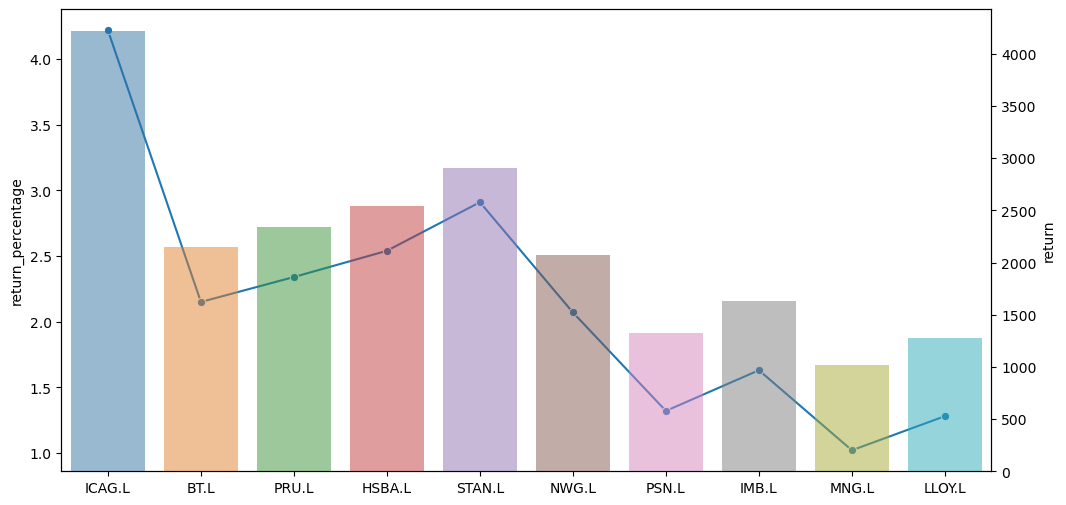

In [23]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data = backtest_df['return_percentage'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()
sns.barplot(data = backtest_df, x='selected_symbols', y='return', alpha=0.5, ax=ax2)
plt.show()

### Conclusion
In this article, we learned about Quantitative Momentum Strategy and it's implementation in Python using DSS API to pick tradable stocks.

We defined a function to authenticate with DSS Rest API and get a token, and further expanded FTSE ChainRic to get the list of all stocks of FTSE 100. We can consider stocks listed on other exchanges to experiment around as well. 

We defined another function to pull intraday data for FTSE ChainRic using DSS Rest API. By performing research given the amount of data being pulled, we can learn different ways of data extraction using DSS API along with extensive data processing.


Further try tuning this strategy accordingly by using several other metrics.